# CVI Experiment Suite

This notebook runs a comprehensive grid search over Characteristic Value Iteration (CVI) hyperparameters and compares performance against classical baselines (VI, Monte Carlo).

In [ ]:
import sys
import os
import numpy as np
import itertools
import pandas as pd
import gymnasium as gym
from tqdm.notebook import tqdm

# CVI Imports
from cvi_rl.envs.registry import make_env
from cvi_rl.algorithms.tabular_vi import value_iteration
from cvi_rl.algorithms.mc import evaluate_policy_monte_carlo
from cvi_rl.algorithms.tabular_cvi import cvi_policy_evaluation, cvi_action_evaluation_from_V, collapse_q_cf_to_scalar_mean
from cvi_rl.cf.grids import make_omega_grid

## 1. Environment Setup

We use a standard tabular environment. Valid options: `"taxi"`, `"gridworld"`, `"frozenlake-8x8"`.

In [3]:
ENV_NAME = "taxi"
GAMMA = 0.9

# Initialize Environment
env_spec, env = make_env(ENV_NAME)
print(f"Initialized {ENV_NAME}: States={env_spec.n_states}, Actions={env_spec.n_actions}")

# Initial Policy (Random)
np.random.seed(42)
random_policy = np.random.randint(0, env_spec.n_actions, size=env_spec.n_states)

# Compute Ground Truth via Classical VI
print("Running Classical Value Iteration for Baseline...")
pi_vi, V_vi, _, _ = value_iteration(env_spec, gamma=GAMMA, termination=1e-8)

# Compute Q_vi from V_vi for direct comparison
# We need Q-values to compare against CVI's collapsed Q(s,a)
Q_vi = np.zeros((env_spec.n_states, env_spec.n_actions))
for s in range(env_spec.n_states):
    for a in range(env_spec.n_actions):
        for prob, next_state, reward, done in env_spec.P[s][a]:
            Q_vi[s, a] += prob * (reward + GAMMA * V_vi[next_state] * (1 - done))

print(f"VI Converged. Q_vi shape: {Q_vi.shape}, Mean Q-value: {Q_vi.mean():.3f}")

Initialized taxi: States=500, Actions=6
Running Classical Value Iteration for Baseline...
VI Converged. Q_vi shape: (500, 6), Mean Q-value: -1.675


## 2. Experiment Grid Definition

We define the hyperparameter space for CVI. We will explore:
1. **Grid Construction**: Strategy (Uniform vs Piecewise, logarithmic, chebyshev, and adaptive), Size (K), Range (W)
2. **Interpolation**: Linear, Polar, PCHIP, Lanczos
3. **Collapse Method**: How we extract the scalar mean from the CF (LS, FFT, Gaussian)

In [ ]:
# Define the parameter grid
param_grid = {
    # Grid Parameters
    "W": [10.0, 20.0],           # Frequency range [-W, W]
    "K": [128, 256, 512],        # Number of grid points
    "grid_strategy": ["uniform", "piecewise_centered", "logarithmic", "chebyshev", "adaptive"],
    
    # CVI Core Parameters
    "interp_method": ["linear", "polar", "pchip", "lanczos"],
    
    # Post-Processing / Collapse Parameters
    "collapse_method": ["ls", "fft", "gaussian"]
}

# Generate all combinations
keys, values = zip(*param_grid.items())
configs = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Total possible configurations: {len(configs)}")

# Filter incompatible combinations
filtered_configs = []
for cfg in configs:
    # FFT assumes uniform grid structure for standard inversion
    # Allow only uniform grids for FFT (could extend to others but needs validation)
    if cfg["collapse_method"] == "fft" and cfg["grid_strategy"] != "uniform":
        continue
        
    filtered_configs.append(cfg)

print(f"Configurations after filtering: {len(filtered_configs)}")
print(f"\nGrid strategy distribution:")
for strategy in param_grid["grid_strategy"]:
    count = sum(1 for cfg in filtered_configs if cfg["grid_strategy"] == strategy)
    print(f"  {strategy:20s}: {count} configs")
print(f"\nExample Config:", filtered_configs[0])

Total possible configurations: 360
Configurations after filtering: 264

Grid strategy distribution:
  uniform             : 72 configs
  piecewise_centered  : 48 configs
  logarithmic         : 48 configs
  chebyshev           : 48 configs
  adaptive            : 48 configs

Example Config: {'W': 10.0, 'K': 128, 'grid_strategy': 'uniform', 'interp_method': 'linear', 'collapse_method': 'ls'}


## 3. Helper Functions for Evaluation

We define metrics to compare the CVI-derived Q-values against the Classical VI Q-values ($Q_{VI}$).

In [5]:
def evaluate_config(config, env_spec, policy, Q_target):
    """
    Runs CVI policy evaluation with the given config and compares to Q_target.
    """
    # 1. Run CVI Policy Evaluation
    # Some interpolation methods might need specific kwargs (e.g. lanczos 'a')
    interp_kwargs = {}
    if config["interp_method"] == "lanczos":
        interp_kwargs = {"a": 3}
    
    V_cf, omegas = cvi_policy_evaluation(
        env_spec,
        policy,
        gamma=GAMMA,
        grid_strategy=config["grid_strategy"],
        W=config["W"],
        K=config["K"],
        interp_method=config["interp_method"],
        interp_kwargs=interp_kwargs
    )
    
    # 2. Compute Action Values CF
    Q_cf = cvi_action_evaluation_from_V(
        env_spec,
        V_cf,
        omegas,
        gamma=GAMMA,
        interp_method=config["interp_method"],
        interp_kwargs=interp_kwargs
    )
    
    # 3. Collapse to Scalar
    # Collapse kwargs dispatch
    collapse_kwargs = {}
    if config["collapse_method"] == "ls":
        collapse_kwargs = {"m": 4}
    elif config["collapse_method"] == "gaussian":
        collapse_kwargs = {"max_w": 2.0}
    elif config["collapse_method"] == "savgol":
        collapse_kwargs = {"window_length": 7}
        
    Q_cvi_scalar = collapse_q_cf_to_scalar_mean(
        omegas,
        Q_cf,
        method=config["collapse_method"],
        **collapse_kwargs
    )
    
    # 4. Metrics
    # State-space error metrics
    errors = Q_cvi_scalar - Q_target
    abs_errors = np.abs(errors)
    squared_errors = errors ** 2
    
    mae = np.mean(abs_errors)           # Mean Absolute Error
    mse = np.mean(squared_errors)       # Mean Squared Error
    rmse = np.sqrt(mse)                 # Root Mean Squared Error
    max_err = np.max(abs_errors)        # Maximum Error
    
    return {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "max_err": max_err,
        "q_mean": np.mean(Q_cvi_scalar)
    }

## 4. Run Experiments

Now we run the grid search over all configurations and collect results.


### Configuration Health Analysis

Not all configurations completed successfully, and some that did produced unreasonably large errors. Let's analyze the "healthy" vs "failed" configurations to identify systematic issues.


In [6]:
# Run grid search
results = []

print(f"Running {len(filtered_configs)} configurations...\n")

for i, config in enumerate(tqdm(filtered_configs)):
    try:
        metrics = evaluate_config(config, env_spec, pi_vi, Q_vi)
        
        # Add config params to results
        result = {**config, **metrics}
        results.append(result)
        
    except Exception as e:
        print(f"\nConfig {i} failed: {config}")
        print(f"Error: {e}\n")
        continue

# Convert to DataFrame
df_results = pd.DataFrame(results)
print(f"\nCompleted {len(df_results)} / {len(filtered_configs)} configurations successfully.")
print(f"\nBest 5 configurations by MAE:")
print(df_results.nsmallest(5, 'mae')[['W', 'K', 'grid_strategy', 'interp_method', 'collapse_method', 'mae', 'mse', 'rmse', 'max_err']])


Running 264 configurations...



  0%|          | 0/264 [00:00<?, ?it/s]


Completed 264 / 264 configurations successfully.

Best 5 configurations by MAE:
        W    K       grid_strategy interp_method collapse_method  \
147  20.0  128  piecewise_centered         polar        gaussian   
171  20.0  128            adaptive         polar        gaussian   
59   10.0  256  piecewise_centered         polar        gaussian   
83   10.0  256            adaptive         polar        gaussian   
259  20.0  512            adaptive         polar        gaussian   

              mae           mse          rmse       max_err  
147  2.062424e-15  5.497748e-30  2.344728e-15  7.105427e-15  
171  2.257083e-15  7.069209e-30  2.658798e-15  4.440892e-15  
59   2.276993e-15  8.202904e-30  2.864071e-15  7.105427e-15  
83   2.723229e-15  8.846939e-30  2.974381e-15  5.329071e-15  
259  2.753649e-15  1.055075e-29  3.248192e-15  8.881784e-15  


## 5. Analysis and Visualization

Analyze the results to understand which hyperparameters work best.


In [10]:
import matplotlib.pyplot as plt

# Overall statistics
print("Summary Statistics:")
print(df_results[['mae', 'mse', 'rmse', 'max_err']].describe())

# Best configuration
best_idx = df_results['mae'].idxmin()
best_config = df_results.loc[best_idx]
print(f"\nBest Configuration:")
print(f"  Grid: {best_config['grid_strategy']}, W={best_config['W']}, K={best_config['K']}")
print(f"  Interpolation: {best_config['interp_method']}")
print(f"  Collapse: {best_config['collapse_method']}")
print(f"  MAE: {best_config['mae']:.6f}")
print(f"  MSE: {best_config['mse']:.6f}")
print(f"  RMSE: {best_config['rmse']:.6f}")
print(f"  Max Error: {best_config['max_err']:.6f}")

# Grouped analysis
print("\n" + "="*60)
print("Error Metrics by Grid Strategy:")
print(df_results.groupby('grid_strategy')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))

print("\n" + "="*60)
print("Error Metrics by Interpolation Method:")
print(df_results.groupby('interp_method')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))

print("\n" + "="*60)
print("Error Metrics by Collapse Method:")
print(df_results.groupby('collapse_method')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))

print("\n" + "="*60)
print("Error Metrics by K (Grid Size):")
print(df_results.groupby('K')[['mae', 'mse', 'rmse']].agg(['mean', 'std', 'min']))


Summary Statistics:
                mae           mse          rmse       max_err
count  2.640000e+02  2.640000e+02  2.640000e+02  2.640000e+02
mean   3.535588e+00  8.905188e+01  5.014072e+00  1.748615e+01
std    4.056422e+00  6.414685e+02  8.009618e+00  3.488363e+01
min    2.062424e-15  5.497748e-30  2.344728e-15  4.440892e-15
25%    3.217961e-02  1.681196e-03  4.099643e-02  7.143229e-02
50%    2.561939e+00  1.814590e+01  4.259701e+00  1.763952e+01
75%    5.550374e+00  4.780928e+01  6.914426e+00  2.111470e+01
max    2.661135e+01  1.006420e+04  1.003205e+02  4.917457e+02

Best Configuration:
  Grid: piecewise_centered, W=20.0, K=128
  Interpolation: polar
  Collapse: gaussian
  MAE: 0.000000
  MSE: 0.000000
  RMSE: 0.000000
  Max Error: 0.000000

Error Metrics by Grid Strategy:
                         mae                                 mse               \
                        mean       std           min        mean          std   
grid_strategy                                    

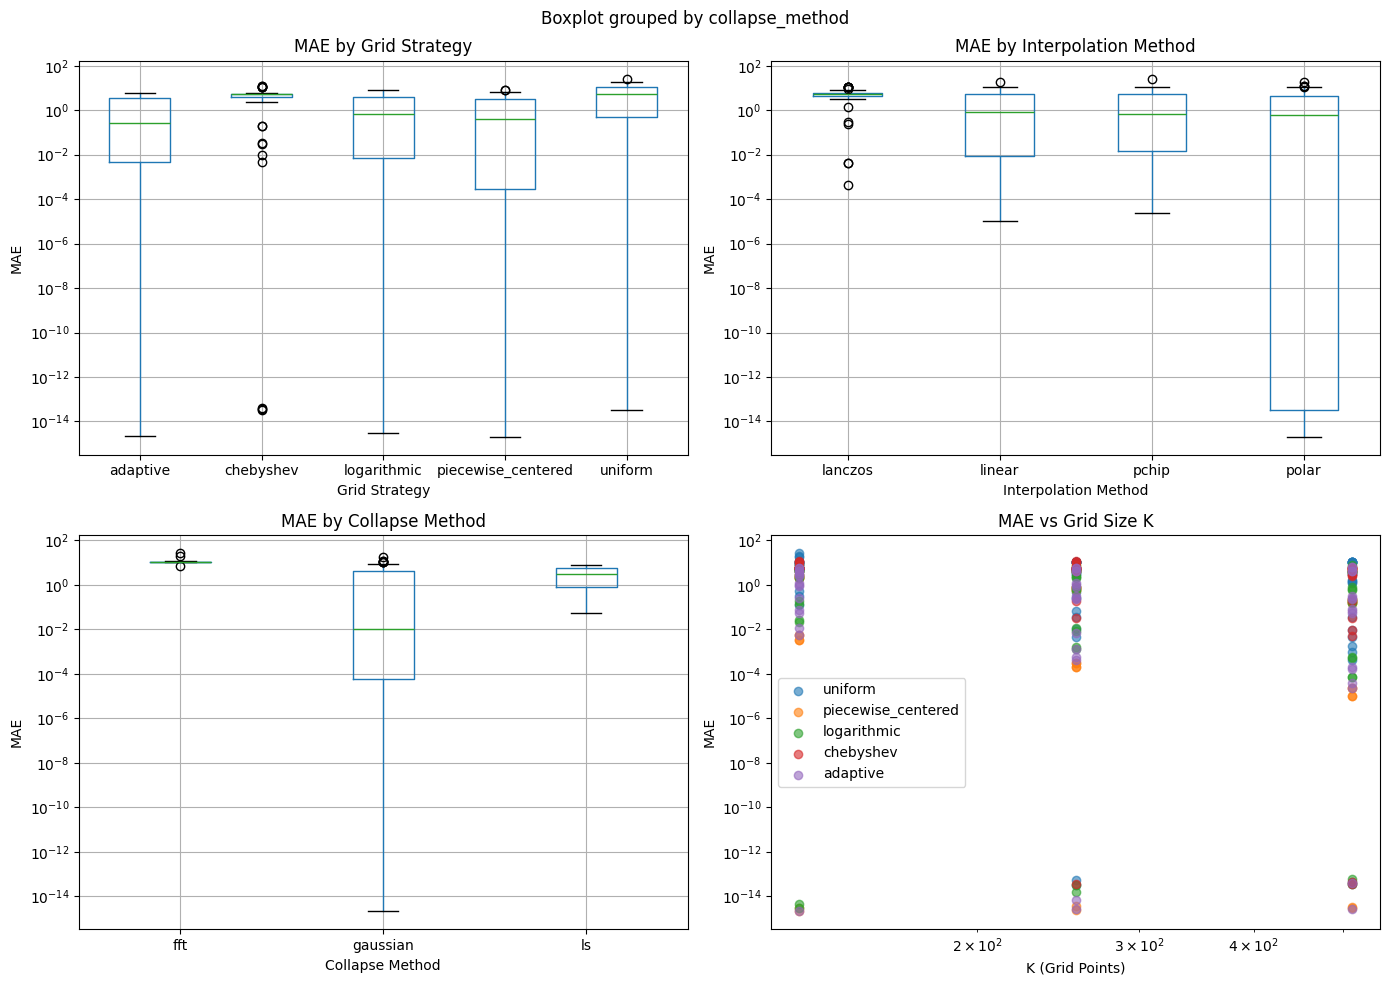

In [11]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE by grid strategy
df_results.boxplot(column='mae', by='grid_strategy', ax=axes[0, 0])
axes[0, 0].set_title('MAE by Grid Strategy')
axes[0, 0].set_xlabel('Grid Strategy')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].set_yscale('log')

# MAE by interpolation method
df_results.boxplot(column='mae', by='interp_method', ax=axes[0, 1])
axes[0, 1].set_title('MAE by Interpolation Method')
axes[0, 1].set_xlabel('Interpolation Method')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_yscale('log')

# MAE by collapse method
df_results.boxplot(column='mae', by='collapse_method', ax=axes[1, 0])
axes[1, 0].set_title('MAE by Collapse Method')
axes[1, 0].set_xlabel('Collapse Method')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_yscale('log')

# MAE vs K (grid size)
for strategy in df_results['grid_strategy'].unique():
    data = df_results[df_results['grid_strategy'] == strategy]
    axes[1, 1].scatter(data['K'], data['mae'], label=strategy, alpha=0.6)
axes[1, 1].set_title('MAE vs Grid Size K')
axes[1, 1].set_xlabel('K (Grid Points)')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].legend()
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()